# Model creation

# Import and declaration
This script sets up the environment for training an audio restoration model using PyTorch. It includes:

- Device configuration (`cuda`, `mps`, or `cpu`) with support for mixed precision if available.
- Import of key libraries: `torchaudio`, `matplotlib`, and `tqdm` for progress tracking.
- Training hyperparameters: batch size, learning rate, number of epochs, FFT parameters, etc.
- File path definitions for clean and degraded audio samples and model checkpoints.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import Spectrogram, AmplitudeToDB
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

if DEVICE == 'cuda':
    from torch.cuda.amp import autocast, GradScaler
else:
    from contextlib import nullcontext
    autocast = nullcontext  
    
    class GradScaler:
        def scale(self, loss): return loss
        def step(self, optimizer): optimizer.step()
        def update(self): pass
        def __getattr__(self, name): return lambda *args, **kwargs: None

BATCH_SIZE   = 8
EPOCHS       = 80
LEARNING_RATE= 5e-5
SAMPLE_RATE  = 16000
N_FFT        = 1024
HOP_LENGTH   = 64    
WIN_LENGTH   = N_FFT
N_FRAMES     = 256  
CLEAR_DIR    = '../../data/train/clean'
DEGRADED_DIR = '../../data/train/degraded'
MODEL_SAVE   = '../../models/UNet_audio_restoration.pth'
CHECKPOINT_DIR = '../../test'

print(f'Device use: {DEVICE}')

Device use: mps


# Dataset

This custom PyTorch `Dataset` loads paired clean and degraded audio files to train an audio restoration model. Key features:

- Converts audio to **power spectrograms** and applies **Amplitude-to-dB scaling**.
- Supports mono conversion and **normalization** per sample.
- Automatically **pads or crops** time dimension to a fixed number of frames.
- Returns a tuple: `(degraded_spectrogram, clean_spectrogram)`.

Example shape: `[channels=1, freq_bins, n_frames]`.

In [ ]:
class AudioPairDataset(Dataset):
    def __init__(self, clean_dir, degraded_dir,
                 sample_rate=16000, n_fft=1024,
                 hop_length=128, n_frames=256):
        self.clean_dir    = clean_dir
        self.degraded_dir = degraded_dir
        self.files        = sorted(os.listdir(clean_dir))
        self.n_frames     = n_frames
        self.spec  = Spectrogram(
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=n_fft,
            power=2.0
        )
        self.to_db = AmplitudeToDB(stype='power')


    def __len__(self):
        return len(self.files)

    def pad_or_crop(self, S):
        C, freq, time = S.shape
        if time < self.n_frames:
            pad_amount = self.n_frames - time
            return F.pad(S, (0, pad_amount))
        else:
            return S[:, : , :self.n_frames]

    def __getitem__(self, idx):
        fn = self.files[idx]
        cw, _ = torchaudio.load(os.path.join(self.clean_dir, fn))
        dw, _ = torchaudio.load(os.path.join(self.degraded_dir, fn))
        cw = cw.mean(0, keepdim=True)
        dw = dw.mean(0, keepdim=True)
        S_c = self.to_db(self.spec(cw))
        S_d = self.to_db(self.spec(dw))
        S_c = (S_c - S_c.mean()) / (S_c.std() + 1e-6)
        S_d = (S_d - S_d.mean()) / (S_d.std() + 1e-6)
        S_c = self.pad_or_crop(S_c)
        S_d = self.pad_or_crop(S_d)
        return S_d, S_c

# Model
This section defines a 2D **U-Net neural network** tailored for audio restoration on spectrograms. The network is composed of modular `UNetBlock` units and follows a classical encoder–decoder structure with skip connections.

---

#### 🔧 `UNetBlock`

A reusable building block consisting of:
- Two `Conv2D` layers (kernel size 3, padding 1)
- Followed by `InstanceNorm2D` (with affine transformation enabled)
- `ReLU` activations applied in-place for efficiency

In [29]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        self.enc1 = UNetBlock(in_ch, 64)
        self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256)
        self.bottleneck = UNetBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = UNetBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = UNetBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = UNetBlock(128, 64)
        self.final_conv = nn.Conv2d(64, out_ch, 1)

    def center_crop(self, src, tgt):
        _,_,h,w = src.shape
        _,_,th,tw = tgt.shape
        dh, dw = (h-th)//2, (w-tw)//2
        return src[:,:,dh:dh+th, dw:dw+tw]

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.up3(b)
        e3c = self.center_crop(e3, d3)
        d3 = self.dec3(torch.cat([d3, e3c], dim=1))
        d2 = self.up2(d3)
        e2c = self.center_crop(e2, d2)
        d2 = self.dec2(torch.cat([d2, e2c], dim=1))
        d1 = self.up1(d2)
        e1c = self.center_crop(e1, d1)
        d1 = self.dec1(torch.cat([d1, e1c], dim=1))
        return self.final_conv(d1)

### Training and Validation Loop Overview

The script trains a U-Net model for audio restoration on spectrogram data. It uses a combination of L1 loss and spectral convergence to optimize perceptual quality.

#### Spectral Convergence

A custom metric to measure how close the predicted and target spectrograms are:

$$
\text{SC}(x, y) = \frac{ \| y - x \|_F }{ \| y \|_F + \varepsilon }
$$

Used alongside L1 loss for training:
$$
\text{Loss} = \text{L1} + 0.3 \cdot \text{SC}
$$

#### Key Features
- 80/20 train-validation split using `AudioPairDataset`
- Mixed precision support (AMP) on CUDA
- Learning rate scheduling (`ReduceLROnPlateau`)
- Periodic and best-model checkpoint saving

Each epoch logs training/validation loss, and the final model is saved after training.

In [ ]:
def spectral_convergence(x, y, eps=1e-6):
    return torch.norm(y - x, p='fro') / (torch.norm(y, p='fro') + eps)

ds = AudioPairDataset(CLEAR_DIR, DEGRADED_DIR,
                      SAMPLE_RATE, N_FFT, HOP_LENGTH, N_FRAMES)
n_val = int(0.2 * len(ds))
train_ds, val_ds = random_split(ds, [len(ds)-n_val, n_val])

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    shuffle=True,  num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=0, pin_memory=True
)

model     = UNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
use_amp = (DEVICE == 'cuda')
scaler  = GradScaler() if use_amp else None

train_losses, val_losses = [], []
best_val = float('inf')

for epoch in range(1, EPOCHS+1):
    model.train()
    run_loss = 0.0

    for deg, clean in tqdm(train_loader, desc=f"Train Epoch: {epoch}/{EPOCHS}"):
        deg = deg.to(DEVICE)
        cl  = clean.to(DEVICE)
        optimizer.zero_grad()

        if use_amp:
            with autocast():
                out = model(deg)
                out = out.clamp(min=-5.0, max=5.0)
                if out.shape != cl.shape:
                    cl = cl[..., :out.size(2), :out.size(3)]

                l1 = F.l1_loss(out, cl)
                sc = spectral_convergence(out, cl)
                loss = l1 + 0.3 * sc

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(deg)
            out = out.clamp(min=-5.0, max=5.0)
            if out.shape != cl.shape:
                cl = cl[..., :out.size(2), :out.size(3)]
            l1 = F.l1_loss(out, cl)
            sc = spectral_convergence(out, cl)
            loss = l1 + 0.3 * sc
            loss.backward()
            optimizer.step()

        run_loss += loss.item()

    avg_train = run_loss / len(train_loader)
    train_losses.append(avg_train)

    model.eval()
    val_run = 0.0
    with torch.no_grad():
        for deg, clean in val_loader:
            deg = deg.to(DEVICE)
            cl  = clean.to(DEVICE)
            out = model(deg)
            out = out.clamp(min=-5.0, max=5.0)
            if out.shape != cl.shape:
                cl = cl[..., :out.size(2), :out.size(3)]
            l1 = F.l1_loss(out, cl)
            sc = spectral_convergence(out, cl)
            val_run += (l1 + 0.1 * sc).item()

    avg_val = val_run / len(val_loader)
    val_losses.append(avg_val)
    scheduler.step(avg_val)

    if epoch % 5 == 0:
        torch.save({'model_state': model.state_dict()},
                   os.path.join(CHECKPOINT_DIR, f'checkpoint_ep{epoch}.pth'))
    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(),
                   os.path.join(CHECKPOINT_DIR, 'best.pth'))

    print(f"Epoch {epoch}: Train Loss = {avg_train:.4f}, Val Loss = {avg_val:.4f}")

torch.save(model.state_dict(), MODEL_SAVE)
print(f"Model saved to {MODEL_SAVE}")

Train Epoch: 1/80: 100%|██████████| 800/800 [42:39<00:00,  3.20s/it]


Epoch 1: Train Loss = 0.5604, Val Loss = 0.4329


Train Epoch: 2/80: 100%|██████████| 800/800 [42:34<00:00,  3.19s/it]


Epoch 2: Train Loss = 0.5309, Val Loss = 0.4249


Train Epoch: 3/80: 100%|██████████| 800/800 [42:57<00:00,  3.22s/it]


Epoch 3: Train Loss = 0.5232, Val Loss = 0.4218


Train Epoch: 4/80: 100%|██████████| 800/800 [42:25<00:00,  3.18s/it]


Epoch 4: Train Loss = 0.5178, Val Loss = 0.4139


Train Epoch: 5/80: 100%|██████████| 800/800 [47:45<00:00,  3.58s/it]  


Epoch 5: Train Loss = 0.5079, Val Loss = 0.4057


Train Epoch: 6/80: 100%|██████████| 800/800 [43:47<00:00,  3.28s/it]


Epoch 6: Train Loss = 0.4936, Val Loss = 0.3948


Train Epoch: 7/80: 100%|██████████| 800/800 [46:10<00:00,  3.46s/it] 


Epoch 7: Train Loss = 0.4857, Val Loss = 0.3883


Train Epoch: 8/80: 100%|██████████| 800/800 [42:37<00:00,  3.20s/it]


Epoch 8: Train Loss = 0.4798, Val Loss = 0.3837


Train Epoch: 9/80: 100%|██████████| 800/800 [42:29<00:00,  3.19s/it]


Epoch 9: Train Loss = 0.4750, Val Loss = 0.3802


Train Epoch: 10/80: 100%|██████████| 800/800 [42:02<00:00,  3.15s/it]


Epoch 10: Train Loss = 0.4721, Val Loss = 0.3791


Train Epoch: 11/80: 100%|██████████| 800/800 [41:39<00:00,  3.12s/it]


Epoch 11: Train Loss = 0.4673, Val Loss = 0.3784


Train Epoch: 12/80: 100%|██████████| 800/800 [42:23<00:00,  3.18s/it]


Epoch 12: Train Loss = 0.4637, Val Loss = 0.3775


Train Epoch: 13/80: 100%|██████████| 800/800 [42:18<00:00,  3.17s/it]


Epoch 13: Train Loss = 0.4606, Val Loss = 0.3792


Train Epoch: 14/80: 100%|██████████| 800/800 [42:28<00:00,  3.19s/it]


Epoch 14: Train Loss = 0.4567, Val Loss = 0.3848


Train Epoch: 15/80: 100%|██████████| 800/800 [46:29<00:00,  3.49s/it]  


Epoch 15: Train Loss = 0.4517, Val Loss = 0.3782


Train Epoch: 16/80: 100%|██████████| 800/800 [42:43<00:00,  3.20s/it]


Epoch 16: Train Loss = 0.4461, Val Loss = 0.3743


Train Epoch: 17/80: 100%|██████████| 800/800 [42:11<00:00,  3.16s/it]


Epoch 17: Train Loss = 0.4416, Val Loss = 0.3739


Train Epoch: 18/80: 100%|██████████| 800/800 [41:14<00:00,  3.09s/it]


Epoch 18: Train Loss = 0.4366, Val Loss = 0.3763


Train Epoch: 19/80: 100%|██████████| 800/800 [53:36<00:00,  4.02s/it]  


Epoch 19: Train Loss = 0.4327, Val Loss = 0.3778


Train Epoch: 20/80: 100%|██████████| 800/800 [41:21<00:00,  3.10s/it]


Epoch 20: Train Loss = 0.4288, Val Loss = 0.3789


Train Epoch: 21/80: 100%|██████████| 800/800 [41:39<00:00,  3.12s/it]


Epoch 21: Train Loss = 0.4266, Val Loss = 0.3758


Train Epoch: 22/80: 100%|██████████| 800/800 [41:46<00:00,  3.13s/it]


Epoch 22: Train Loss = 0.4121, Val Loss = 0.3701


Train Epoch: 23/80: 100%|██████████| 800/800 [41:41<00:00,  3.13s/it]


Epoch 23: Train Loss = 0.4071, Val Loss = 0.3723


Train Epoch: 24/80: 100%|██████████| 800/800 [41:28<00:00,  3.11s/it]


Epoch 24: Train Loss = 0.4049, Val Loss = 0.3713


Train Epoch: 25/80: 100%|██████████| 800/800 [41:15<00:00,  3.09s/it]


Epoch 25: Train Loss = 0.4011, Val Loss = 0.3712


Train Epoch: 26/80: 100%|██████████| 800/800 [41:32<00:00,  3.12s/it]


Epoch 26: Train Loss = 0.3990, Val Loss = 0.3712


Train Epoch: 27/80: 100%|██████████| 800/800 [41:39<00:00,  3.12s/it]


Epoch 27: Train Loss = 0.3882, Val Loss = 0.3703


Train Epoch: 28/80: 100%|██████████| 800/800 [41:45<00:00,  3.13s/it]


Epoch 28: Train Loss = 0.3854, Val Loss = 0.3706


Train Epoch: 29/80: 100%|██████████| 800/800 [41:53<00:00,  3.14s/it]


Epoch 29: Train Loss = 0.3828, Val Loss = 0.3701


Train Epoch: 30/80: 100%|██████████| 800/800 [42:08<00:00,  3.16s/it]


Epoch 30: Train Loss = 0.3804, Val Loss = 0.3718


Train Epoch: 31/80: 100%|██████████| 800/800 [49:40<00:00,  3.73s/it]  


Epoch 31: Train Loss = 0.3740, Val Loss = 0.3695


Train Epoch: 32/80: 100%|██████████| 800/800 [41:03<00:00,  3.08s/it]


Epoch 32: Train Loss = 0.3723, Val Loss = 0.3715


Train Epoch: 33/80: 100%|██████████| 800/800 [45:28<00:00,  3.41s/it]  


Epoch 33: Train Loss = 0.3703, Val Loss = 0.3720


Train Epoch: 34/80: 100%|██████████| 800/800 [42:46<00:00,  3.21s/it]


Epoch 34: Train Loss = 0.3689, Val Loss = 0.3716


Train Epoch: 35/80: 100%|██████████| 800/800 [42:46<00:00,  3.21s/it]


Epoch 35: Train Loss = 0.3674, Val Loss = 0.3732


Train Epoch: 36/80: 100%|██████████| 800/800 [1:08:39<00:00,  5.15s/it]  


Epoch 36: Train Loss = 0.3637, Val Loss = 0.3718


Train Epoch: 37/80: 100%|██████████| 800/800 [52:19<00:00,  3.92s/it]  


Epoch 37: Train Loss = 0.3627, Val Loss = 0.3720


Train Epoch: 38/80: 100%|██████████| 800/800 [51:17<00:00,  3.85s/it]  


Epoch 38: Train Loss = 0.3618, Val Loss = 0.3723


Train Epoch: 39/80: 100%|██████████| 800/800 [41:36<00:00,  3.12s/it]  


Epoch 39: Train Loss = 0.3609, Val Loss = 0.3735


Train Epoch: 40/80: 100%|██████████| 800/800 [41:56<00:00,  3.15s/it]


Epoch 40: Train Loss = 0.3588, Val Loss = 0.3724


Train Epoch: 41/80: 100%|██████████| 800/800 [59:58<00:00,  4.50s/it]   


Epoch 41: Train Loss = 0.3583, Val Loss = 0.3725


Train Epoch: 42/80: 100%|██████████| 800/800 [41:45<00:00,  3.13s/it]


Epoch 42: Train Loss = 0.3577, Val Loss = 0.3730


Train Epoch: 43/80: 100%|██████████| 800/800 [41:54<00:00,  3.14s/it]


Epoch 43: Train Loss = 0.3573, Val Loss = 0.3734


Train Epoch: 44/80: 100%|██████████| 800/800 [41:48<00:00,  3.14s/it]


Epoch 44: Train Loss = 0.3562, Val Loss = 0.3728


Train Epoch: 45/80: 100%|██████████| 800/800 [41:39<00:00,  3.12s/it]


Epoch 45: Train Loss = 0.3560, Val Loss = 0.3732


Train Epoch: 46/80: 100%|██████████| 800/800 [41:48<00:00,  3.14s/it]


Epoch 46: Train Loss = 0.3558, Val Loss = 0.3728


Train Epoch: 47/80: 100%|██████████| 800/800 [41:29<00:00,  3.11s/it]


Epoch 47: Train Loss = 0.3555, Val Loss = 0.3735


Train Epoch: 48/80: 100%|██████████| 800/800 [41:50<00:00,  3.14s/it]


Epoch 48: Train Loss = 0.3550, Val Loss = 0.3734


Train Epoch: 49/80: 100%|██████████| 800/800 [42:35<00:00,  3.19s/it]  


Epoch 49: Train Loss = 0.3548, Val Loss = 0.3733


Train Epoch: 50/80: 100%|██████████| 800/800 [41:58<00:00,  3.15s/it]


Epoch 50: Train Loss = 0.3546, Val Loss = 0.3734


Train Epoch: 51/80: 100%|██████████| 800/800 [41:49<00:00,  3.14s/it]


Epoch 51: Train Loss = 0.3545, Val Loss = 0.3736


Train Epoch: 52/80: 100%|██████████| 800/800 [42:02<00:00,  3.15s/it]


Epoch 52: Train Loss = 0.3542, Val Loss = 0.3736


Train Epoch: 53/80: 100%|██████████| 800/800 [41:38<00:00,  3.12s/it]


Epoch 53: Train Loss = 0.3541, Val Loss = 0.3735


Train Epoch: 54/80: 100%|██████████| 800/800 [42:00<00:00,  3.15s/it]


Epoch 54: Train Loss = 0.3541, Val Loss = 0.3736


Train Epoch: 55/80: 100%|██████████| 800/800 [41:41<00:00,  3.13s/it]


Epoch 55: Train Loss = 0.3540, Val Loss = 0.3736


Train Epoch: 56/80: 100%|██████████| 800/800 [42:02<00:00,  3.15s/it]


Epoch 56: Train Loss = 0.3539, Val Loss = 0.3736


Train Epoch: 57/80: 100%|██████████| 800/800 [41:42<00:00,  3.13s/it]


Epoch 57: Train Loss = 0.3538, Val Loss = 0.3736


Train Epoch: 58/80: 100%|██████████| 800/800 [41:46<00:00,  3.13s/it]


Epoch 58: Train Loss = 0.3539, Val Loss = 0.3735


Train Epoch: 59/80: 100%|██████████| 800/800 [43:22<00:00,  3.25s/it]  


Epoch 59: Train Loss = 0.3537, Val Loss = 0.3735


Train Epoch: 60/80: 100%|██████████| 800/800 [42:04<00:00,  3.16s/it]


Epoch 60: Train Loss = 0.3536, Val Loss = 0.3736


Train Epoch: 61/80: 100%|██████████| 800/800 [45:06<00:00,  3.38s/it] 


Epoch 61: Train Loss = 0.3537, Val Loss = 0.3736


Train Epoch: 62/80: 100%|██████████| 800/800 [42:07<00:00,  3.16s/it]


Epoch 62: Train Loss = 0.3537, Val Loss = 0.3736


Train Epoch: 63/80: 100%|██████████| 800/800 [41:55<00:00,  3.14s/it]


Epoch 63: Train Loss = 0.3536, Val Loss = 0.3736


Train Epoch: 64/80: 100%|██████████| 800/800 [42:24<00:00,  3.18s/it]


Epoch 64: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 65/80: 100%|██████████| 800/800 [42:22<00:00,  3.18s/it]


Epoch 65: Train Loss = 0.3536, Val Loss = 0.3736


Train Epoch: 66/80: 100%|██████████| 800/800 [44:14<00:00,  3.32s/it] 


Epoch 66: Train Loss = 0.3536, Val Loss = 0.3736


Train Epoch: 67/80: 100%|██████████| 800/800 [43:02<00:00,  3.23s/it]


Epoch 67: Train Loss = 0.3536, Val Loss = 0.3736


Train Epoch: 68/80: 100%|██████████| 800/800 [43:13<00:00,  3.24s/it]


Epoch 68: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 69/80: 100%|██████████| 800/800 [42:22<00:00,  3.18s/it]


Epoch 69: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 70/80: 100%|██████████| 800/800 [42:06<00:00,  3.16s/it]


Epoch 70: Train Loss = 0.3536, Val Loss = 0.3736


Train Epoch: 71/80: 100%|██████████| 800/800 [42:15<00:00,  3.17s/it]


Epoch 71: Train Loss = 0.3534, Val Loss = 0.3736


Train Epoch: 72/80: 100%|██████████| 800/800 [43:04<00:00,  3.23s/it]  


Epoch 72: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 73/80: 100%|██████████| 800/800 [42:11<00:00,  3.16s/it]


Epoch 73: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 74/80: 100%|██████████| 800/800 [42:24<00:00,  3.18s/it]


Epoch 74: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 75/80: 100%|██████████| 800/800 [42:05<00:00,  3.16s/it]


Epoch 75: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 76/80: 100%|██████████| 800/800 [41:21<00:00,  3.10s/it]


Epoch 76: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 77/80: 100%|██████████| 800/800 [41:48<00:00,  3.14s/it]


Epoch 77: Train Loss = 0.3534, Val Loss = 0.3736


Train Epoch: 78/80: 100%|██████████| 800/800 [41:56<00:00,  3.15s/it]


Epoch 78: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 79/80: 100%|██████████| 800/800 [41:57<00:00,  3.15s/it]


Epoch 79: Train Loss = 0.3535, Val Loss = 0.3736


Train Epoch: 80/80: 100%|██████████| 800/800 [41:32<00:00,  3.12s/it]


Epoch 80: Train Loss = 0.3535, Val Loss = 0.3736
Model saved to ../../models/UNet_audio_restoration.pth


### Loss Curve Visualization

At the end of training, the script plots the L1 loss over epochs for both training and validation sets:

```python
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')

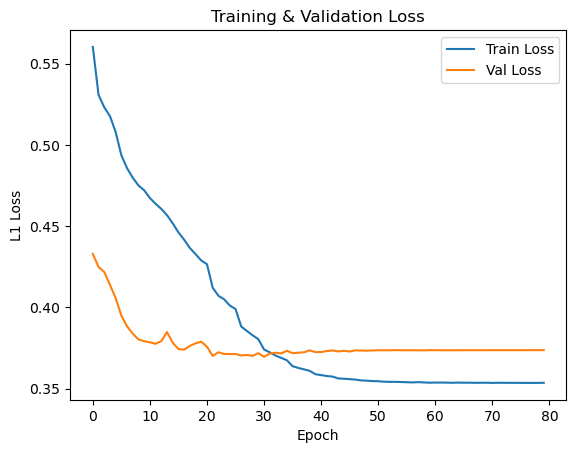

In [31]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()